In [1]:
import os
import glob
import shutil
import time

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

import eli5
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from eli5.sklearn import PermutationImportance

C:\Users\Ebarnes\AppData\Local\Continuum\anaconda3\envs\tflow\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Ebarnes\AppData\Local\Continuum\anaconda3\envs\tflow\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Pull in CSVs
all_hexagons = pd.read_csv("all_hexagons_50c_grouped_withCounties.csv")
records = pd.read_csv("june29_1589_records.csv")

all_hexagons.set_index('subwatershed', inplace=True)

# Join data frames to make master file. Join key = 'subwatershed'
joined = records.join(all_hexagons, on='subwatershed')

In [3]:
# Drop columns not needed.
# Comment out a line to leave in for processing.
drop_list = [
    'Unnamed: 0',       # Always remove
#     'area',
#     'perimeter',
#     'circulatory_ratio',
#     'relief',
#     'avg_slope',
#     'watershed_length',
#     'elongation_ratio',
#     'drainage_density',
#     'shape_factor',
#     'relief_ratio',
#     'ruggedness',
#     'aae_area',
#     'buildings_aae_count',
#     'x_area',
#     'buildings_x_count',
#     'water_bodies_area',
#     'dams_count',
#     'bridges_count',
#     'streets_km',
#     'railroads_km',
#     'population',
#     'population_density',
#     'avg_median_income',
#     'housing_density',
#     'population_change',
#     'dependent_population_pct',
#     'dist_to_stream_avg..m.',
#     'dist_to_stream_stdev..m.',
#     'lu_22_area',
#     'lu_23_area',
#     'lu_24_area',
#     'lu_41_area',
#     'lu_82_area',
#     'avg_impervious_percent',
#     'orb100yr06h',
#     'orb100yr12h',
#     'orb100yr24h',
#     'orb25yr06h',
#     'orb25yr12h',
#     'orb25yr24h',
#     'orb2yr06h',
#     'orb2yr12h',
#     'orb2yr24h',
#     'orb50yr06h',
#     'orb50yr12h',
#     'orb50yr24h',
#     'orb100yr06ha_am',
#     'orb100yr12ha_am',
#     'orb100yr24ha_am',
#     'orb25yr06ha_am',
#     'orb25yr12ha_am',
#     'orb25yr24ha_am',
#     'orb2yr06ha_am',
#     'orb2yr12ha_am',
#     'orb2yr24ha_am',
#     'orb50yr06ha_am',
#     'orb50yr12ha_am',
#     'orb50yr24ha_am',
#     'policy_total_building_coverage_avg',
    'File'          # Always remove
]

# Drop columns in 'drop_list'
joined.drop(
    drop_list,
    axis=1,
    inplace=True
)

In [4]:
# Drop 'bad data'
joined = joined[joined['subwatershed'] != 41900000200]
# Drop rows with blanks
joined = joined.dropna()

In [5]:
# Create directory
folder_name = time.strftime("%Y%m%d_%H.%M.%S")
try:
    os.mkdir('Runs/{}'.format(folder_name))
    out_directory = os.path.join('Runs', folder_name)
except OSError:
    print('Something went wrong')
    
# Save the joined data to csv
joined.to_csv(os.path.join(out_directory, 'joined_data.csv'))

In [6]:
# Normalize the rows to 0-1, excluding the watershed identifier
scaler = MinMaxScaler(feature_range=(0, 1))
column_list = list(joined.columns)
column_list.remove('subwatershed')

joined[column_list] = scaler.fit_transform(joined[column_list])

scaler_by = scaler.scale_[44]
scaler_min = scaler.min_[44]

print("Note: {} values were scaled by multiplying by {:.12f} and adding {:.10f}".format(
    column_list[44],
    scaler_by,
    scaler_min)
)

Note: orb50yr12h values were scaled by multiplying by 0.000064279745 and adding 0.6427331748


In [7]:
# REMOVED UNTIL 0s FOR MONETARY CLAIMS VALUES CAN BE ACCOUNTED FOR
# i_rows = len(joined)
# print('Initial row count for data: ' + str(i_rows))
# usable_data = joined[(np.abs(stats.zscore(joined)) < 3).all(axis=1)]
# u_rows = len(usable_data)
# print("- Identified and removed {} outliers.".format(str(i_rows-u_rows)))
# print('Updated row count for all data: ' + str(u_rows))

In [8]:
joined.to_csv(os.path.join(out_directory, 'final_data_scaled.csv'))

In [9]:
# Use 70% of the data for training, 15% for testing, 15% for validation.
# Subset data for training, testing, validation
training_df = joined.sample(frac=.7, random_state=663168)
testing_df = joined.loc[~joined.index.isin(training_df.index)]
validation_df = testing_df.sample(frac=.5, random_state=663168)
testing_df = testing_df.loc[~testing_df.index.isin(validation_df.index)]

In [10]:
# Print number of input nodes for network
# Number of columns minus 2 (subwatershed, Unnamed: 0)
node_count = int(len(list(training_df.columns)) - 2)
print('Number of input nodes: ' + str(node_count))

Number of input nodes: 59


In [11]:
# Format the training data set
training_df.drop(['subwatershed'], axis=1, inplace=True)

# Create column list for feature importance chart
column_list = training_df.drop('claims_total_building_insurance_coverage_avg', axis=1).columns.tolist()

# Format the separate test data set
testing_df.drop(['subwatershed'], axis=1, inplace=True)

# Format the validation data
validation_df.drop(['subwatershed'], axis=1, inplace=True)

In [12]:
# Predicting 'claims_total_building_insurance_coverage_avg'
prediction_column = 'claims_total_building_insurance_coverage_avg'

# Format training data
x_train = training_df.drop(prediction_column, axis=1).values
y_train = training_df[prediction_column].values

# Format the testing data
x_test = testing_df.drop(prediction_column, axis=1).values
y_test = testing_df[prediction_column].values

# Format the validation data
x_validate = validation_df.drop(prediction_column, axis=1).values
y_validate = validation_df[prediction_column].values

In [13]:
# Define the model
def base_model(input_nodes=59):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(86, input_dim=input_nodes, activation='relu', name='Initial_layer'))
#     model.add(tf.keras.layers.Dropout(.2, name='Dropout 1'))
    model.add(tf.keras.layers.Dense(172, activation='relu', name='Dense_1'))
    model.add(tf.keras.layers.Dropout(.2, name='Dropout_1'))
    model.add(tf.keras.layers.Dense(86, activation='relu', name='Dense_2'))
    model.add(tf.keras.layers.Dropout(.2, name='Dropout_2'))
    model.add(tf.keras.layers.Dense(1, activation='linear', name='Output_layer'))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model


epochs = 30

In [14]:
# Log with TensorBoard
logger = tf.keras.callbacks.TensorBoard(
    log_dir=os.path.join('logs', folder_name),
    write_graph=True,
    histogram_freq=1
)

In [15]:
# Define model parameters with KerasRegressor
my_model = KerasRegressor(
    build_fn=base_model,
    input_nodes=59,
    epochs=epochs
)

In [16]:
# Train the model
history = my_model.fit(
    x_train,
    y_train,
    validation_data=(x_validate, y_validate),
    epochs=epochs,
    shuffle=False,
    verbose=2,
    callbacks=[logger]
)

Train on 1089 samples, validate on 234 samples
Epoch 1/30
1089/1089 - 0s - loss: 0.0302 - val_loss: 0.0097
Epoch 2/30
1089/1089 - 0s - loss: 0.0149 - val_loss: 0.0092
Epoch 3/30
1089/1089 - 0s - loss: 0.0139 - val_loss: 0.0085
Epoch 4/30
1089/1089 - 0s - loss: 0.0137 - val_loss: 0.0086
Epoch 5/30
1089/1089 - 0s - loss: 0.0137 - val_loss: 0.0083
Epoch 6/30
1089/1089 - 0s - loss: 0.0126 - val_loss: 0.0084
Epoch 7/30
1089/1089 - 0s - loss: 0.0125 - val_loss: 0.0080
Epoch 8/30
1089/1089 - 0s - loss: 0.0115 - val_loss: 0.0078
Epoch 9/30
1089/1089 - 0s - loss: 0.0119 - val_loss: 0.0078
Epoch 10/30
1089/1089 - 0s - loss: 0.0112 - val_loss: 0.0080
Epoch 11/30
1089/1089 - 0s - loss: 0.0115 - val_loss: 0.0078
Epoch 12/30
1089/1089 - 0s - loss: 0.0113 - val_loss: 0.0076
Epoch 13/30
1089/1089 - 0s - loss: 0.0111 - val_loss: 0.0079
Epoch 14/30
1089/1089 - 0s - loss: 0.0114 - val_loss: 0.0081
Epoch 15/30
1089/1089 - 0s - loss: 0.0116 - val_loss: 0.0081
Epoch 16/30
1089/1089 - 0s - loss: 0.0114 - val

In [17]:
print("Vizualize in Conda:\nC:\\Users\\Ebarnes\\Documents\\GitHub\\machine_learning\\ML_Indiana>\ntensorboard --logdir=logs\\{}".format(folder_name))

Vizualize in Conda:
C:\Users\Ebarnes\Documents\GitHub\machine_learning\ML_Indiana>
tensorboard --logdir=logs\20200702_14.36.02


In [18]:
perm = PermutationImportance(my_model, random_state=1).fit(x_train, y_train)
weights = eli5.explain_weights(perm, feature_names=column_list)
weights_dict = eli5.formatters.as_dict.format_as_dict(weights)

1089/1089 [==============================] - ETA: 0s - loss: 0.008 - 0s 21us/sample - loss: 0.0136


In [19]:
# Collect a dataframe of weight data
weights_df = pd.DataFrame()
weights_df['feature'] = list(thisdict['feature'] for thisdict in weights_dict['feature_importances']['importances'])
weights_df['weight'] = list(thisdict['weight'] for thisdict in weights_dict['feature_importances']['importances'])
weights_df['Std Dev'] = list(thisdict['std'] for thisdict in weights_dict['feature_importances']['importances'])
weights_df['Value'] = list(thisdict['value'] for thisdict in weights_dict['feature_importances']['importances'])

In [20]:
train_mse = my_model.score(x_train, y_train, verbose=0)
test_mse = my_model.score(x_test, y_test, verbose=0)

# Store true MSE values, calculate RMSE values
train_mse = abs(train_mse)
test_mse = abs(test_mse)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Mean squared error (MSE) values:')
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
print('Train RMSE: %.3f, Test RMSE: %.3f' % (train_rmse, test_rmse))

Mean squared error (MSE) values:
Train: 0.009, Test: 0.007
Train RMSE: 0.097, Test RMSE: 0.083


In [ ]:
# Expected and observed predictions
predictions = my_model.predict(x_test)

# Scale data back to original form:
predictions = predictions / scaler_by
predictions = predictions - scaler_min
y_test = y_test / scaler_by
y_test = y_test - scaler_min

observed = pd.Series(predictions)
expected = pd.Series(y_test)

pva_df = pd.DataFrame()
pva_df['observed'] = observed
pva_df['expected'] = expected

pva_df.to_csv(out_directory + '/expected_observed.csv')

In [37]:
pva_df.head()

,observed,expected
202,872.952576,-0.642733
186,373.560577,-0.642733
183,311.955566,-0.642733
40,1034.324951,-0.642733
56,924.839600,-0.642733


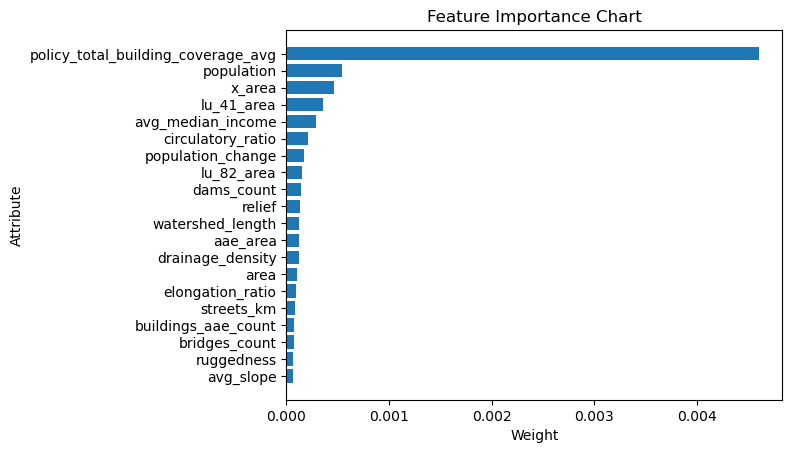

In [22]:
# Plot item weights
features = weights_df['feature'].tolist()
weights = weights_df['weight']
y_pos = np.arange(len(features))
pyplot.rcdefaults()
fig, ax = pyplot.subplots()
ax.barh(y_pos, weights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.set_ylabel('Attribute')
ax.invert_yaxis()
ax.set_xlabel('Weight')
ax.set_title('Feature Importance Chart')
pyplot.savefig((out_directory + '/weights_plot.png'), bbox_inches='tight')
pyplot.show()

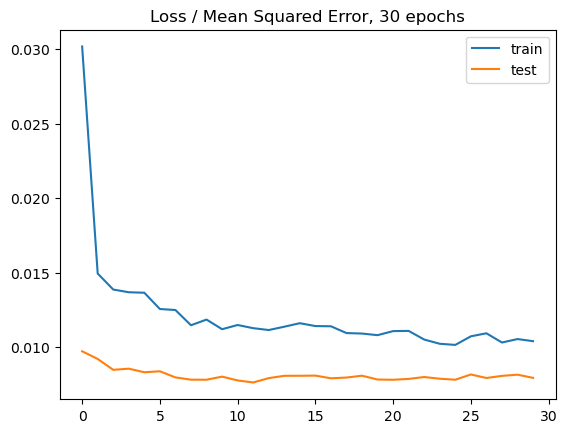

In [23]:
# Plot loss during training
pyplot.title('Loss / Mean Squared Error, {} epochs'.format(str(epochs)))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig((out_directory + '/loss_plot.png'))
pyplot.show()

In [24]:
# Save training, validation, testing data and model
training_df.to_csv(os.path.join(out_directory, '/training_data.csv'))
validation_df.to_csv(os.path.join(out_directory, '/validation_data.csv'))
testing_df.to_csv(os.path.join(out_directory, '/testing_data.csv'))
my_model.model.save(out_directory + '/trained_model.h5')
print('Model saved to disk.')

Model saved to disk.
